In [1]:
# Interface MatPlotLib with IPython
%matplotlib inline

In [2]:
# Import dependencies
import numpy as np
import astropy.stats as ap_stats
import scipy.optimize as optimize
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set plot border width
mpl.rcParams['axes.linewidth'] = 2

In [3]:
# Set initial periods in days
P_rot = 27.4
P_cad = 37.3
P_20b = 3.69611525
P_20c = 10.85409089
P_20d = 77.61130017
P_20e = 6.09852281
P_20f = 19.57758478
P_20g = 34.940

# Set initial semi-amplitudes in m/s
K_20b = 4.20
K_20c = 3.84
K_20d = 1.57
K_20e = 0.18
K_20f = 0.19
K_20g = 4.10

In [4]:
# Load HIRES Radial velocities (m/s)
HIRES_data = np.loadtxt('../data/RV_HIRES.txt', delimiter=',')
JD_HIRES = HIRES_data[:, 0]
RV_HIRES = HIRES_data[:, 1]
RV_err_HIRES = HIRES_data[:, 2]

# Load HARPS-N Radial velocities (km/s)
HARPSN_data = np.loadtxt('../data/RV_HARPS_N.txt', delimiter=',')
JD_HARPSN = HARPSN_data[:, 0]
RV_HARPSN = HARPSN_data[:, 1]
RV_err_HARPSN = HARPSN_data[:, 2]

# Reject outliers from the HARPS-N RVs
good_RVs = (RV_HARPSN < 0) * (RV_err_HARPSN < 0.005)
JD_HARPSN = JD_HARPSN[good_RVs]
RV_HARPSN = RV_HARPSN[good_RVs]
RV_err_HARPSN = RV_err_HARPSN[good_RVs]

# Rescale to m/s and mean substract
RV_HARPSN *= 1000
RV_err_HARPSN *= 1000
RV_HIRES -= RV_HIRES.mean()
RV_HARPSN -= RV_HARPSN.mean()

# Concatenate time series
JD = np.append(JD_HIRES, JD_HARPSN)
RV = np.append(RV_HIRES, RV_HARPSN)
RV_err = np.append(RV_err_HIRES, RV_err_HARPSN)

# Compute indices for HIRES and HARPS-N data
HIRES = np.zeros_like(JD, dtype=np.bool)
HARPSN = np.zeros_like(JD, dtype=np.bool)
for ii, date in enumerate(JD):
    if date in JD_HIRES:
        HIRES[ii] = True
    else:
        HARPSN[ii] = True

# Center the Julian dates
JD0 = 2455000.0
JD -= JD0

# Load HARPS-N S-index (unitless)
CaII = np.loadtxt('../data/CaII_HARPS_N.txt', delimiter=',')
N_S = CaII.shape[0]
JD_S = CaII[good_RVs[:N_S], 0] - JD0
S = CaII[good_RVs[:N_S], 1]
S_err = CaII[good_RVs[:N_S], 2]

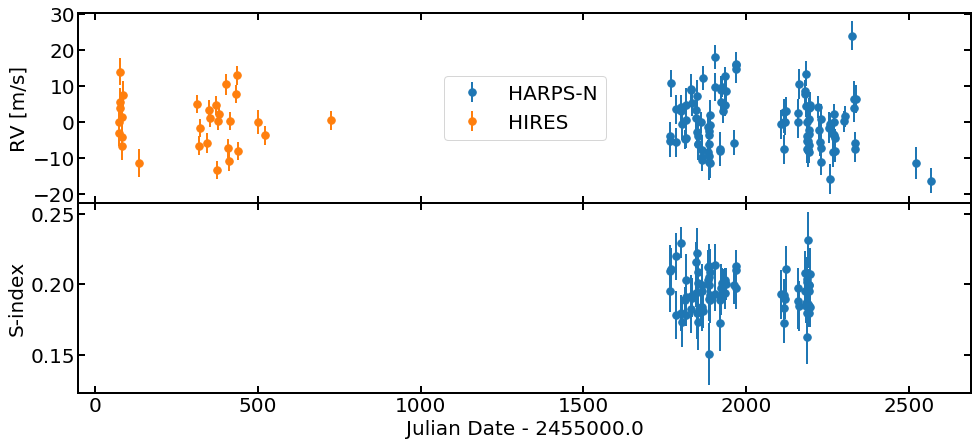

In [5]:
# Plot the time series

baseline = JD.max() - JD.min()
x_limits = (JD.min() - 0.05 * baseline, JD.max() + 0.05 * baseline)

plt.figure(figsize=(16, 7))

plt.subplot(211)
plt.errorbar(JD[HARPSN], RV[HARPSN], RV_err[HARPSN], markersize=15, linewidth=2, fmt='.', label='HARPS-N')
plt.errorbar(JD[HIRES], RV[HIRES], RV_err[HIRES], markersize=15, linewidth=2, fmt='.', label='HIRES')
plt.legend(fontsize=20, loc='center')
plt.xlim(x_limits)
plt.tick_params(axis='both', which='major', direction='in', left=True, bottom=True, top=True, right=True, length=7, width=2)
plt.xticks(fontsize=2)
plt.yticks(fontsize=20)
plt.ylabel('RV [m/s]', fontsize=20)

plt.subplot(212)
plt.errorbar(JD_S, S, S_err, markersize=15, linewidth=2, fmt='.', label='HARPS-N S-index')
plt.xlim(x_limits)
plt.tick_params(axis='both', which='major', direction='in', left=True, bottom=True, top=True, right=True, length=7, width=2)
plt.xticks(fontsize=20)
plt.yticks((0.15, 0.2, 0.25), fontsize=20)
plt.xlabel(f'Julian Date - {JD0}', fontsize=20)
plt.ylabel('S-index', fontsize=20)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('../images/data_timeseries.pdf')
plt.savefig('../images/data_timeseries.png', dpi=600)

In [6]:
# Compute generalized Lomb-Scargle periodogram and window function of S-index

# 5000 periods from 10 days to 100 days
freqs = np.linspace(1/100, 1/10, 5000)

# Window function (Eq. 3 from <https://arxiv.org/pdf/1504.06629.pdf>)
theta = 2 * np.pi * freqs.reshape(-1, 1, 1) * (JD_S.reshape(1, 1, -1) - JD_S.reshape(1, -1, 1))
S_window_power = np.cos(theta).sum(axis=-1).sum(axis=-1)

# S-index GLS periodogram
S_LS = ap_stats.LombScargle(JD_S, S, dy=S_err, fit_mean=True)
S_LS_power = S_LS.power(freqs, method='slow')

In [7]:
# Function to compute Keplerian RV of an eccentric orbit
def keplerian(t, amplitude=1, period=1, phi=np.pi, ecc=0, omega=np.pi):

    # Mean anomoly and initial guess for eccentric anomoly
    mean_anomoly = 2 * np.pi * t / period - phi
    ecc_anomoly = np.copy(mean_anomoly)

    # Use Newton's method to numerically estimate eccentric anomoly
    while np.any(ecc_anomoly - ecc * np.sin(ecc_anomoly) - mean_anomoly > 5e-6):
        numerator = mean_anomoly + ecc * np.sin(ecc_anomoly) - ecc * ecc_anomoly * np.cos(ecc_anomoly)
        denominator = 1 - ecc * np.cos(ecc_anomoly)
        ecc_anomoly = numerator / denominator

    # Compute true anomoly from eccentric anomoly
    true_anomoly = 2 * np.arctan(np.sqrt((1 + ecc) / (1 - ecc)) * np.tan(ecc_anomoly / 2))

    # Compute RV
    return amplitude * (np.cos(omega + true_anomoly) + ecc * np.cos(omega))

# Function to return a model function and its chi squared function
def build_model(JD, RV_data, RV_data_err=None, HARPSN=None):

    if HARPSN is None:
        def model(theta):
            RV_model = np.zeros_like(JD)
            for planet_parameters in theta.reshape(-1, 5):
                RV_model += keplerian(JD, *planet_parameters)
            return RV_model
    else:
        def model(theta):
            RV_model = np.zeros_like(JD)
            for planet_parameters in theta[:-1].reshape(-1, 5):
                RV_model += keplerian(JD, *planet_parameters)
            RV_model[HARPSN] += theta[-1]
            return RV_model

    if RV_data_err is None:
        def chi_squared(theta):
            return np.sum((RV_data - model(theta))**2)
    else:
        def chi_squared(theta):
            return np.sum(((RV_data - model(theta)) / RV_data_err)**2)

    return model, chi_squared

In [8]:
# Build the model with the data
model, chi_squared = build_model(JD, RV, RV_err, HARPSN)

# Initial guesses for fit parameters
theta_0 = np.array([K_20b, P_20b, 0, 0, 0,
                    K_20c, P_20c, 0, 0, 0,
                    K_20d, P_20d, 0, 0, 0,
                    0])

# Fit parameter boundaries
bounds = [(0, np.inf), (P_20b, P_20b), (-np.pi, np.pi), (0, 0.30), (-np.pi, np.pi),
          (0, np.inf), (P_20c, P_20c), (-np.pi, np.pi), (0, 0.17), (-np.pi, np.pi),
          (0, np.inf), (P_20d, P_20d), (-np.pi, np.pi), (0, 0.28), (-np.pi, np.pi),
          (-100, 100)]

# Fit the model to the data and print the result
result = optimize.minimize(fun=chi_squared, x0=theta_0, bounds=bounds, options={'disp':True})
print(result)

# Compute the residuals and mean subtract
residuals = RV - model(result.x)
residuals -= residuals.mean()

      fun: 392.59518411600254
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.17271939e-01,  1.44128014e+04,  1.56489932e-01,  7.12943802e+00,
       -1.56671831e-01,  5.57832891e-01, -2.44724806e+03, -2.04472030e+00,
        3.89636625e+00,  2.04503294e+00, -2.34809931e+00, -4.16383727e+00,
       -6.29063379e-01,  1.36523795e+01,  6.29063379e-01, -1.10341034e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1717
      nit: 90
   status: 0
  success: True
        x: array([ 4.58486703,  3.69611525, -0.26730317,  0.        ,  0.15230043,
        3.63867998, 10.85409089,  0.60396384,  0.        , -0.56323371,
        1.33869933, 77.61130017, -0.69081659,  0.        ,  0.85517169,
        0.48773285])


In [9]:
# Compute generalized Lomb-Scargle periodogram and window function of RVs and the residuals

# 5000 periods from 10 days to 100 days
freqs = np.linspace(1/100, 1/10, 5000)

# Window function (Eq. 3 from <https://arxiv.org/pdf/1504.06629.pdf>)
theta = 2 * np.pi * freqs.reshape(-1, 1, 1) * (JD[HARPSN].reshape(1, 1, -1) - JD[HARPSN].reshape(1, -1, 1))
window_power = np.cos(theta).sum(axis=-1).sum(axis=-1)

# Raw HARPS-N RVs GLS periodogram
RV_LS = ap_stats.LombScargle(JD[HARPSN], RV[HARPSN], dy=RV_err[HARPSN], fit_mean=True)
RV_LS_power = RV_LS.power(freqs, method='slow')

# Raw HARPS-N RV residuals GLS periodogram
residual_LS = ap_stats.LombScargle(JD[HARPSN], residuals[HARPSN], dy=RV_err[HARPSN], fit_mean=True)
residual_LS_power = residual_LS.power(freqs, method='slow')

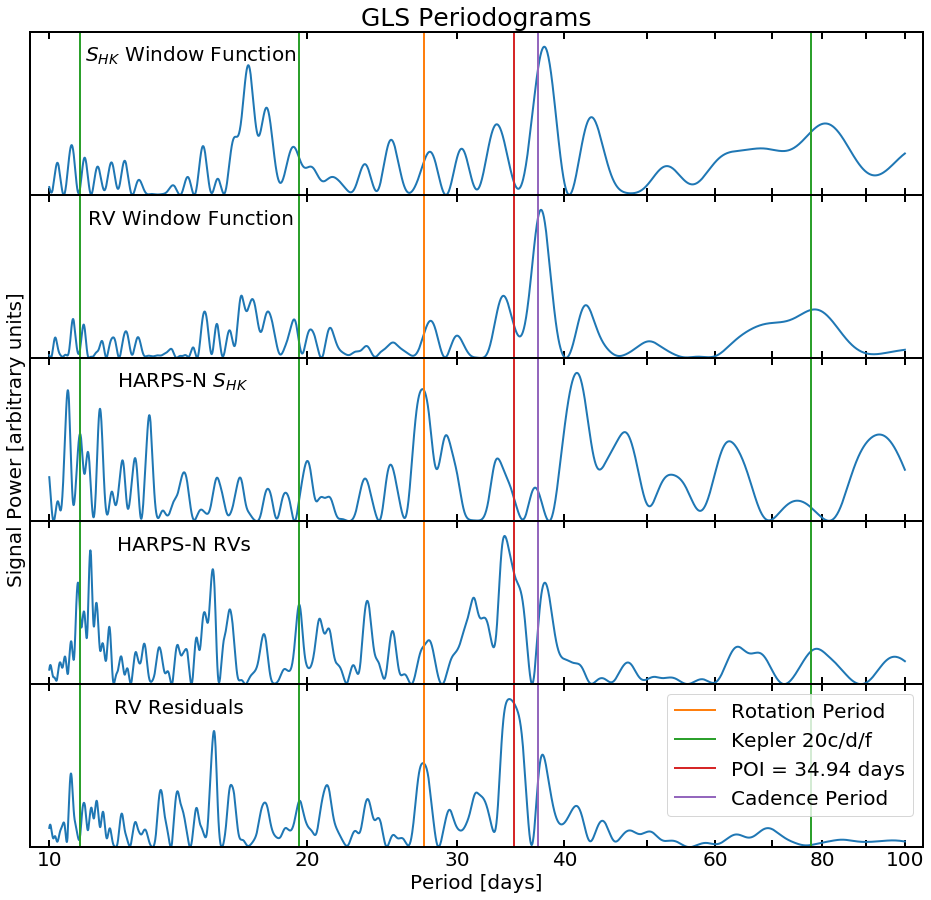

In [10]:
# Plot all the window functions and GLS periodograms

plt.figure(figsize=(16, 15))

plt.subplot(511)
plt.semilogx(1/freqs, S_window_power, linewidth=2)
Y_ub = 1.1 * S_window_power.max()
plt.plot([P_rot, P_rot], [0, Y_ub], linewidth=2, label='Rotation Period')
plt.plot([P_20c, P_20c, P_20d, P_20d, P_20f, P_20f],
         [-0.1, 1.1 * Y_ub, 1.1 * Y_ub, -0.1, -0.1, 1.1 * Y_ub],
         linewidth=2, label='Kepler 20c/d/f')
plt.plot([P_20g, P_20g], [0, Y_ub], linewidth=2, label=f'POI = {P_20g} days')
plt.plot([P_cad, P_cad], [0, Y_ub], linewidth=2, label='Cadence Period')
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, right=True, top=True, length=7, width=2)
plt.xlim((9.5, 105))
plt.ylim((0, Y_ub))
plt.xticks((10, 20, 30, 40, 60, 80, 100))
plt.yticks(())
plt.title('GLS Periodograms', fontsize=25)
plt.text(11.0, 0.82*Y_ub, '$S_{HK}$ Window Function', fontsize=20)

plt.subplot(512)
plt.semilogx(1/freqs, window_power, linewidth=2)
Y_ub = 1.1 * window_power.max()
plt.plot([P_rot, P_rot], [0, Y_ub], linewidth=2, label='Rotation Period')
plt.plot([P_20c, P_20c, P_20d, P_20d, P_20f, P_20f],
         [-0.1, 1.1 * Y_ub, 1.1 * Y_ub, -0.1, -0.1, 1.1 * Y_ub],
         linewidth=2, label='Kepler 20c/d/f')
plt.plot([P_20g, P_20g], [0, Y_ub], linewidth=2, label=f'POI = {P_20g} days')
plt.plot([P_cad, P_cad], [0, Y_ub], linewidth=2, label='Cadence Period')
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, right=True, top=True, length=7, width=2)
plt.xlim((9.5, 105))
plt.ylim((0, Y_ub))
plt.xticks((10, 20, 30, 40, 60, 80, 100))
plt.yticks(())
plt.text(11.1, 0.82*Y_ub, 'RV Window Function', fontsize=20)

plt.subplot(513)
plt.semilogx(1/freqs, S_LS_power, linewidth=2)
Y_ub = 1.1 * S_LS_power.max()
plt.plot([P_rot, P_rot], [0, Y_ub], linewidth=2, label='Rotation Period')
plt.plot([P_20c, P_20c, P_20d, P_20d, P_20f, P_20f],
         [-0.1, 1.1 * Y_ub, 1.1 * Y_ub, -0.1, -0.1, 1.1 * Y_ub],
         linewidth=2, label='Kepler 20c/d/f')
plt.plot([P_20g, P_20g], [0, Y_ub], linewidth=2, label=f'POI = {P_20g} days')
plt.plot([P_cad, P_cad], [0, Y_ub], linewidth=2, label='Cadence Period')
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, right=True, top=True, length=7, width=2)
plt.xlim((9.5, 105))
plt.ylim((0, Y_ub))
plt.xticks((10, 20, 30, 40, 60, 80, 100))
plt.yticks(())
plt.ylabel('Signal Power [arbitrary units]', fontsize=20)
plt.text(12.0, 0.82*Y_ub, 'HARPS-N $S_{HK}$', fontsize=20)

plt.subplot(514)
plt.semilogx(1/freqs, RV_LS_power, linewidth=2)
Y_ub = 1.1 * RV_LS_power.max()
plt.plot([P_rot, P_rot], [0, Y_ub], linewidth=2, label='Rotation Period')
plt.plot([P_20c, P_20c, P_20d, P_20d, P_20f, P_20f],
         [-0.1, 1.1 * Y_ub, 1.1 * Y_ub, -0.1, -0.1, 1.1 * Y_ub],
         linewidth=2, label='Kepler 20c/d/f')
plt.plot([P_20g, P_20g], [0, Y_ub], linewidth=2, label=f'POI = {P_20g} days')
plt.plot([P_cad, P_cad], [0, Y_ub], linewidth=2, label='Cadence Period')
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, right=True, top=True, length=7, width=2)
plt.xlim((9.5, 105))
plt.ylim((0, Y_ub))
plt.xticks((10, 20, 30, 40, 60, 80, 100))
plt.yticks(())
plt.text(12.0, 0.82*Y_ub, 'HARPS-N RVs', fontsize=20)

plt.subplot(515)
plt.semilogx(1/freqs, residual_LS_power, linewidth=2)
Y_ub = 1.1 * residual_LS_power.max()
plt.plot([P_rot, P_rot], [0, Y_ub], linewidth=2, label='Rotation Period')
plt.plot([P_20c, P_20c, P_20d, P_20d, P_20f, P_20f],
         [-0.1, 1.1 * Y_ub, 1.1 * Y_ub, -0.1, -0.1, 1.1 * Y_ub],
         linewidth=2, label='Kepler 20c/d/f')
plt.plot([P_20g, P_20g], [0, Y_ub], linewidth=2, label=f'POI = {P_20g} days')
plt.plot([P_cad, P_cad], [0, Y_ub], linewidth=2, label='Cadence Period')
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, right=True, top=True, length=7, width=2)
plt.xlim((9.5, 105))
plt.ylim((0, Y_ub))
plt.xticks((10, 20, 30, 40, 60, 80, 100), (10, 20, 30, 40, 60, 80, 100), fontsize=20)
plt.yticks(())
plt.xlabel('Period [days]', fontsize=20)
plt.text(11.9, 0.82*Y_ub, 'RV Residuals', fontsize=20)

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('../images/gls.pdf')
plt.savefig('../images/gls.png', dpi=600)